<a href="https://colab.research.google.com/github/ehddnr301/dacon_motion/blob/master/motion_pytorch_hrnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!rm -rf /content/gdrive/MyDrive/dacon-motion/train_imgs_folder

In [3]:
!rm -rf /content/gdrive/MyDrive/dacon-motion/test_imgs_folder

In [4]:
!pip install torchinfo

In [5]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 7.8MB/s 
     |████████████████████████████████| 952kB 12.4MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65163 sha256=1ab8e88dfb0e1afd811f15ae6a92f77b6bfa5f5fe9a3ede223c1e693c73f7ce3
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [6]:
!pip install -U albumentations_experimental

In [7]:
!git clone https://github.com/ehddnr301/pytorch-image-models.git

Cloning into 'pytorch-image-models'...
remote: Enumerating objects: 4604, done.
remote: Total 4604 (delta 0), reused 0 (delta 0), pack-reused 4604
Receiving objects: 100% (4604/4604), 15.77 MiB | 30.42 MiB/s, done.
Resolving deltas: 100% (3316/3316), done.


In [8]:
!mv pytorch-image-models timmm

In [9]:
!cd timmm && pip install .

Processing /content/timmm
  Created wheel for timm: filename=timm-0.4.4-cp37-none-any.whl size=287653 sha256=11302d0530f56845624dc276bccb47e37a2ddb2fcb67a3f99a3d499f8ebb4bab
  Stored in directory: /tmp/pip-ephem-wheel-cache-okmufvrj/wheels/54/b9/02/8a014ced29a3023ae1cb7c399966644596eecd7265d47a44c7
Successfully built timm


In [10]:
from timmm import timm

In [11]:
!unzip -n '/content/gdrive/MyDrive/dacon-motion/train_imgs.zip' -d '/content/gdrive/MyDrive/dacon-motion/train_imgs_folder'

Archive:  /content/gdrive/MyDrive/dacon-motion/train_imgs.zip
  inflating: /content/gdrive/MyDrive/dacon-motion/train_imgs_folder/001-1-1-01-Z17_A-0000001.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/train_imgs_folder/001-1-1-01-Z17_A-0000003.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/train_imgs_folder/001-1-1-01-Z17_A-0000005.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/train_imgs_folder/001-1-1-01-Z17_A-0000007.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/train_imgs_folder/001-1-1-01-Z17_A-0000009.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/train_imgs_folder/001-1-1-01-Z17_A-0000011.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/train_imgs_folder/001-1-1-01-Z17_A-0000013.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/train_imgs_folder/001-1-1-01-Z17_A-0000015.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/train_imgs_folder/001-1-1-01-Z17_A-0000017.jpg  
  inflating: /content/gdrive/MyDrive/dacon-moti

In [12]:
!unzip -n '/content/gdrive/MyDrive/dacon-motion/test_imgs.zip' -d '/content/gdrive/MyDrive/dacon-motion/test_imgs_folder'

Archive:  /content/gdrive/MyDrive/dacon-motion/test_imgs.zip
  inflating: /content/gdrive/MyDrive/dacon-motion/test_imgs_folder/649-2-4-32-Z148_A-0000001.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/test_imgs_folder/649-2-4-32-Z148_A-0000003.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/test_imgs_folder/649-2-4-32-Z148_A-0000005.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/test_imgs_folder/649-2-4-32-Z148_A-0000007.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/test_imgs_folder/649-2-4-32-Z148_A-0000009.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/test_imgs_folder/649-2-4-32-Z148_A-0000011.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/test_imgs_folder/649-2-4-32-Z148_A-0000013.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/test_imgs_folder/649-2-4-32-Z148_A-0000015.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motion/test_imgs_folder/649-2-4-32-Z148_A-0000017.jpg  
  inflating: /content/gdrive/MyDrive/dacon-motio

In [13]:
import os
from typing import Tuple, Sequence, Callable
import csv
import cv2
import random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
import torch.optim as optim
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader, random_split
from torchinfo import summary
import matplotlib.pyplot as plt


import albumentations
from albumentations.pytorch import ToTensorV2, ToTensor
from albumentations_experimental import HorizontalFlipSymmetricKeypoints

from torchvision import transforms
import timm

In [14]:
# random seed
random_seed = 301
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)


IMAGE_HEIGHT = 1024
IMAGE_WIDTH = 1024
IMAGE_CHANNELS=3
EPOCHS=30
BATCH_SIZE = 4

PATH_TRAIN_DATASET='/content/gdrive/MyDrive/dacon-motion/train_imgs_folder/'
PATH_TEST_DATASET='/content/gdrive/MyDrive/dacon-motion/test_imgs_folder/'
PATH_TRAIN_ANS_CSV='/content/gdrive/MyDrive/dacon-motion/train_df.csv'
SUB_DF = '/content/gdrive/MyDrive/dacon-motion/sample_submission.csv'
PATH_TRAIN_CSV='/content/gdrive/MyDrive/dacon-motion/split_train_df.csv'
PATH_VALID_CSV='/content/gdrive/MyDrive/dacon-motion/split_val_df.csv'

In [15]:
df = pd.read_csv(PATH_TRAIN_ANS_CSV)
df.head(2)

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,neck_x,neck_y,left_palm_x,left_palm_y,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,001-1-1-01-Z17_A-0000001.jpg,1046.389631,344.757881,1041.655294,329.820225,1059.429507,334.48423,1020.117796,338.890539,1048.000000,343.000000,992.0,394.0,1054.0,400.0,956.0,368.0,1134.0,371.0,1003.497242,327.640085,1078.0,341.0,999.0,570.0,1046.0,573.0,995.0,695.0,1054.0,698.0,983.000000,820.000000,1042.0,829.0,1019.107277,373.766222,1013.137360,316.311695,1067.00000,335.0,1019.484230,455.000000,1026.515770,514.054730,998.578836,826.718013,1063.204067,838.827465
1,001-1-1-01-Z17_A-0000003.jpg,1069.850679,340.711494,1058.608552,324.593690,1075.242111,325.59369,1041.422997,331.694815,1065.593682,333.968459,1010.0,398.0,1077.0,386.0,974.0,398.0,1144.0,337.0,1004.000000,346.000000,1094.0,326.0,1020.0,557.0,1069.0,567.0,1013.0,583.0,1072.0,697.0,1003.843781,678.797029,1042.0,829.0,1047.279440,362.031898,1017.383112,332.890539,1081.18738,323.0,1046.953248,454.062706,1058.766231,508.797029,1002.265676,699.062706,1066.376234,841.499445


In [16]:
error_list=[317, 869, 873, 877, 911, 1559, 1560, 1562, 1566, 1575, 1577, 1578, 1582, 1606, 1607, 1622, 1623, 1624, 1625, 1629, 3968, 4115, 4116, 4117, 4118, 4119, 4120, 4121, 4122, 4123, 4124, 4125, 4126, 4127, 4128, 4129, 4130, 4131, 4132, 4133, 4134, 4135, 4136, 4137, 4138, 4139, 4140, 4141, 4142, 4143, 4144, 4145, 4146, 4147, 4148, 4149, 4150, 4151, 4152, 4153, 4154, 4155, 4156, 4157, 4158, 4159, 4160, 4161, 4162, 4163, 4164, 4165, 4166, 4167, 4168, 4169, 4170, 4171, 4172, 4173, 4174, 4175, 4176, 4177, 4178, 4179, 4180, 4181, 4182, 4183, 4184, 4185, 4186, 4187, 4188, 4189, 4190, 4191, 4192, 4193, 4194]

In [17]:
df.drop(error_list, inplace=True)

In [18]:
df

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,neck_x,neck_y,left_palm_x,left_palm_y,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,001-1-1-01-Z17_A-0000001.jpg,1046.389631,344.757881,1041.655294,329.820225,1059.429507,334.484230,1020.117796,338.890539,1048.000000,343.000000,992.000000,394.000000,1054.000000,400.000000,956.000000,368.000000,1134.000000,371.000000,1003.497242,327.640085,1078.000000,341.000000,999.000000,570.000000,1046.000000,573.000000,995.0,695.0,1054.0,698.0,983.000000,820.000000,1042.000000,829.000000,1019.107277,373.766222,1013.137360,316.311695,1067.000000,335.000000,1019.484230,455.000000,1026.515770,514.054730,998.578836,826.718013,1063.204067,838.827465
1,001-1-1-01-Z17_A-0000003.jpg,1069.850679,340.711494,1058.608552,324.593690,1075.242111,325.593690,1041.422997,331.694815,1065.593682,333.968459,1010.000000,398.000000,1077.000000,386.000000,974.000000,398.000000,1144.000000,337.000000,1004.000000,346.000000,1094.000000,326.000000,1020.000000,557.000000,1069.000000,567.000000,1013.0,583.0,1072.0,697.0,1003.843781,678.797029,1042.000000,829.000000,1047.279440,362.031898,1017.383112,332.890539,1081.187380,323.000000,1046.953248,454.062706,1058.766231,508.797029,1002.265676,699.062706,1066.376234,841.499445
2,001-1-1-01-Z17_A-0000005.jpg,1084.475902,337.000008,1078.717997,323.757889,1095.648412,325.242119,1061.039884,329.351571,1086.461032,334.109461,1020.000000,381.000000,1083.000000,389.000000,984.000000,362.000000,1163.000000,372.000000,1027.507419,327.383120,1111.000000,340.000000,1016.000000,552.000000,1061.000000,556.000000,1018.0,674.0,1070.0,696.0,987.703151,788.867342,1044.000000,826.000000,1063.029716,358.679953,1042.374777,319.031541,1101.000000,334.000000,1044.538960,442.054730,1052.844144,495.890539,989.437847,808.757889,1066.071417,841.749554
3,001-1-1-01-Z17_A-0000007.jpg,1042.320047,361.452689,1037.907194,344.117804,1050.328382,353.913729,1016.844144,340.913737,1042.164191,359.351579,968.000000,392.000000,1010.000000,411.000000,941.812612,339.703151,1109.000000,441.000000,971.654931,328.648429,1066.812604,383.406310,972.000000,571.000000,1000.000000,559.000000,991.0,700.0,1110.0,469.0,991.406302,816.132650,1133.000000,591.000000,1007.302983,374.179405,981.842327,329.109461,1057.406318,372.461040,982.937294,458.109462,990.375124,507.624866,1001.305177,829.233767,1159.516499,599.389997
4,001-1-1-01-Z17_A-0000009.jpg,1058.046395,343.164191,1046.717997,331.703163,1058.132650,331.781079,1031.258806,338.593690,1049.812620,338.187380,997.000000,393.000000,1054.000000,395.000000,961.000000,423.000000,1132.000000,360.000000,988.676303,357.688297,1080.000000,337.000000,1000.000000,567.000000,1043.000000,570.000000,1017.0,673.0,1059.0,701.0,998.406302,784.570501,1040.000000,827.000000,1036.318945,366.195727,999.777421,349.829291,1069.648429,334.109461,1024.843791,453.687572,1034.391088,510.843791,998.625231,805.218921,1059.625956,839.765102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4110,641-2-4-31-Z148_E-0000023.jpg,1082.034196,329.542198,1100.547074,327.690910,1085.119676,322.754143,1120.294145,375.207299,1090.056443,358.545708,1088.307748,442.349808,984.202129,407.565738,1020.525854,386.948427,899.218809,356.237783,989.815210,251.821592,879.256891,241.072867,882.503777,576.708877,824.921319,553.249357,742.0,675.0,635.0,616.0,758.808126,873.151902,639.377843,779.

In [19]:
x_coor = [col for col in df.columns if '_x' in col]
y_coor = [col for col in df.columns if '_y' in col]

In [20]:
val_name_list = []
check_list = []

In [21]:
def spliting(x):
  x1 = x.split('000')[0]
  if check_list.count(x1) < 1:
    check_list.append(x1)
    val_name_list.append(x)

In [22]:
df['image'].apply(spliting)

0       None
1       None
2       None
3       None
4       None
        ... 
4110    None
4111    None
4112    None
4113    None
4114    None
Name: image, Length: 4094, dtype: object

In [23]:
val_df = df[df['image'].isin(val_name_list)]

In [24]:
train_df = df[~df['image'].isin(val_name_list)]

In [25]:
val_df.head(2)

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,neck_x,neck_y,left_palm_x,left_palm_y,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,001-1-1-01-Z17_A-0000001.jpg,1046.389631,344.757881,1041.655294,329.820225,1059.429507,334.48423,1020.117796,338.890539,1048.0,343.0,992.0,394.0,1054.0,400.0,956.0,368.0,1134.0,371.0,1003.497242,327.640085,1078.000000,341.0,999.0,570.0,1046.0,573.0,995.0,695.0,1054.0,698.0,983.0,820.0,1042.000000,829.000000,1019.107277,373.766222,1013.137360,316.311695,1067.000000,335.00000,1019.484230,455.000000,1026.51577,514.054730,998.578836,826.718013,1063.204067,838.827465
11,001-1-1-01-Z17_B-0000001.jpg,1022.593682,387.164183,1023.703143,377.109461,1011.000000,377.00000,1000.882188,385.757881,977.0,386.0,1034.0,459.0,955.0,456.0,1099.0,424.0,880.0,429.0,1050.000000,396.000000,934.461048,396.0,1030.0,636.0,977.0,637.0,1031.0,766.0,977.0,767.0,1033.0,884.0,973.867334,889.781079,988.842311,422.524106,1030.507395,389.648421,950.086255,390.05473,988.559671,521.067055,1005.10323,577.729035,1054.094607,898.210578,986.633559,909.858998


In [26]:
train_df.head(2)

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,neck_x,neck_y,left_palm_x,left_palm_y,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
1,001-1-1-01-Z17_A-0000003.jpg,1069.850679,340.711494,1058.608552,324.593690,1075.242111,325.593690,1041.422997,331.694815,1065.593682,333.968459,1010.0,398.0,1077.0,386.0,974.0,398.0,1144.0,337.0,1004.000000,346.00000,1094.0,326.0,1020.0,557.0,1069.0,567.0,1013.0,583.0,1072.0,697.0,1003.843781,678.797029,1042.0,829.0,1047.279440,362.031898,1017.383112,332.890539,1081.18738,323.0,1046.953248,454.062706,1058.766231,508.797029,1002.265676,699.062706,1066.376234,841.499445
2,001-1-1-01-Z17_A-0000005.jpg,1084.475902,337.000008,1078.717997,323.757889,1095.648412,325.242119,1061.039884,329.351571,1086.461032,334.109461,1020.0,381.0,1083.0,389.0,984.0,362.0,1163.0,372.0,1027.507419,327.38312,1111.0,340.0,1016.0,552.0,1061.0,556.0,1018.0,674.0,1070.0,696.0,987.703151,788.867342,1044.0,826.0,1063.029716,358.679953,1042.374777,319.031541,1101.00000,334.0,1044.538960,442.054730,1052.844144,495.890539,989.437847,808.757889,1066.071417,841.749554


In [27]:
train_imgs = train_df.iloc[:, 0].to_numpy()
motions = train_df.iloc[:, 1:]
columns = motions.columns.to_list()[::2]
class_labels = [label.replace('_x', '').replace('_y', '') for label in columns]
train_keypoints = []
for motion in motions.to_numpy():
    a_train_keypoints = []
    for i in range(0, motion.shape[0], 2):
        a_train_keypoints.append((float(motion[i]), float(motion[i+1])))
    train_keypoints.append(a_train_keypoints)
train_keypoints = np.array(train_keypoints)

In [28]:
val_imgs = val_df.iloc[:, 0].to_numpy()
motions = val_df.iloc[:, 1:]
columns = motions.columns.to_list()[::2]
class_labels = [label.replace('_x', '').replace('_y', '') for label in columns]
val_keypoints = []
for motion in motions.to_numpy():
    a_val_keypoints = []
    for i in range(0, motion.shape[0], 2):
        a_val_keypoints.append((float(motion[i]), float(motion[i+1])))
    val_keypoints.append(a_val_keypoints)
val_keypoints = np.array(val_keypoints)

In [29]:
len(val_keypoints), len(val_imgs)

(260, 260)

In [30]:
len(train_keypoints), len(train_imgs)

(3834, 3834)

In [31]:
class_labels

['nose',
 'left_eye',
 'right_eye',
 'left_ear',
 'right_ear',
 'left_shoulder',
 'right_shoulder',
 'left_elbow',
 'right_elbow',
 'left_wrist',
 'right_wrist',
 'left_hip',
 'right_hip',
 'left_knee',
 'right_knee',
 'left_ankle',
 'right_ankle',
 'neck',
 'left_palm',
 'right_palm',
 'spine2(back)',
 'spine1(waist)',
 'left_instep',
 'right_instep']

In [32]:
from sklearn.model_selection import train_test_split

# train, valid = train_test_split(df, test_size=0.05, random_state=random_seed)

In [33]:
class MotionDataset(Dataset):
    """__init__ and __len__ functions are the same as in TorchvisionDataset"""
    def __init__(self, data_dir, imgs, keypoints, class_labels=None, data_transforms=None):
        self.data_dir = data_dir
        self.imgs = imgs
        self.keypoints = keypoints
        self.class_labels = class_labels
        self.data_transforms = data_transforms

    def __getitem__(self, idx):
        # Read an image with OpenCV
        img = cv2.imread(os.path.join(self.data_dir, self.imgs[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        keypoints = self.keypoints[idx]
    
        if self.data_transforms:
            augmented = self.data_transforms(image=img, keypoints=keypoints, class_labels=self.class_labels)
            img = augmented['image']
            keypoints = augmented['keypoints']
            keypoints = [(x/1024, y/1024) for x,y in keypoints]

        keypoints = np.array(keypoints).flatten()

        return img, keypoints
    
    def __len__(self):
        return len(self.imgs)

In [34]:
class TestDataset(Dataset):
    """__init__ and __len__ functions are the same as in TorchvisionDataset"""
    def __init__(self, data_dir, imgs, data_transforms=None):
        self.data_dir = data_dir
        self.imgs = imgs
        self.data_transforms = data_transforms

    def __getitem__(self, idx):
        filename = self.imgs[idx]
        # Read an image with OpenCV
        img = cv2.imread(os.path.join(self.data_dir, self.imgs[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.data_transforms:
            augmented = self.data_transforms(image=img)
            img = augmented['image']

        return filename, img
    
    def __len__(self):
        return len(self.imgs)
    


In [35]:
# X_train, X_val, y_train, y_val = train_test_split(imgs, keypoints, test_size=0.1, random_state=42)

In [91]:
transforms_train = albumentations.Compose([
      albumentations.Crop(426, 56, 1450, 1080),
      albumentations.OneOf([
                HorizontalFlipSymmetricKeypoints(symmetric_keypoints={
                'left':'right'
                }, p=1),
                albumentations.Rotate(limit=180, p=1),
        ], p=1),
      albumentations.OneOf([                    
        albumentations.RandomBrightness(p=1),
        albumentations.MotionBlur(blur_limit=[3,20], p=1),
      ], p=0.5),
      albumentations.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
      ToTensorV2()
], keypoint_params=albumentations.KeypointParams(format='xy', label_fields=['class_labels'], remove_invisible=False))

transforms_valid = albumentations.Compose([
    albumentations.Crop(426, 56, 1450, 1080),
    albumentations.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ToTensorV2()
], keypoint_params=albumentations.KeypointParams(format='xy', label_fields=['class_labels'], remove_invisible=False))

transforms_test = albumentations.Compose([
    albumentations.Crop(426, 56, 1450, 1080),
    albumentations.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ToTensorV2()
])


/usr/local/lib/python3.7/dist-packages/albumentations_experimental/augmentations/keypoint_utils.py:19: UserWarning: Found points without pairs in symmetric transform: [0, 1]
  warnings.warn("Found points without pairs in symmetric transform: " + str(without_pair))


In [92]:
# trainset = MotionDataset(PATH_TRAIN_DATASET, PATH_TRAIN_CSV, transforms_train)
# valset = MotionDataset(PATH_TRAIN_DATASET, PATH_VALID_CSV, transforms_valid)
# testset = MotionDataset(PATH_TEST_DATASET, SUB_DF, transforms_test)
test_imgs = os.listdir(PATH_TEST_DATASET)
trainset = MotionDataset(PATH_TRAIN_DATASET, train_imgs, train_keypoints, data_transforms=transforms_train, class_labels=class_labels)
valset = MotionDataset(PATH_TRAIN_DATASET, val_imgs, val_keypoints, data_transforms=transforms_valid, class_labels=class_labels)
testset = TestDataset(PATH_TEST_DATASET, test_imgs, data_transforms=transforms_test)

train_loader = DataLoader(trainset, batch_size=2)
val_loader = DataLoader(valset, batch_size=4)
test_loader = DataLoader(testset, batch_size=2, shuffle=False)

In [93]:
# sample, keypointss = trainset[1000]
sample, _ = trainset[205]

In [94]:
# keypointss = keypointss * 1024

In [95]:
def custom_imshow(img):
  img = img.numpy()
  plt.figure(figsize=(12,12))
  plt.imshow(np.transpose(img, (1, 2, 0)))
  plt.show()
# def custom_imshow(img, keypointss):
#   img = img.numpy()
#   plt.figure(figsize=(12,12))
#   for j in range(0,len(keypointss),2):
#     plt.plot(keypointss[j], keypointss[j+1],'rx')
#   plt.imshow(np.transpose(img, (1, 2, 0)))
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


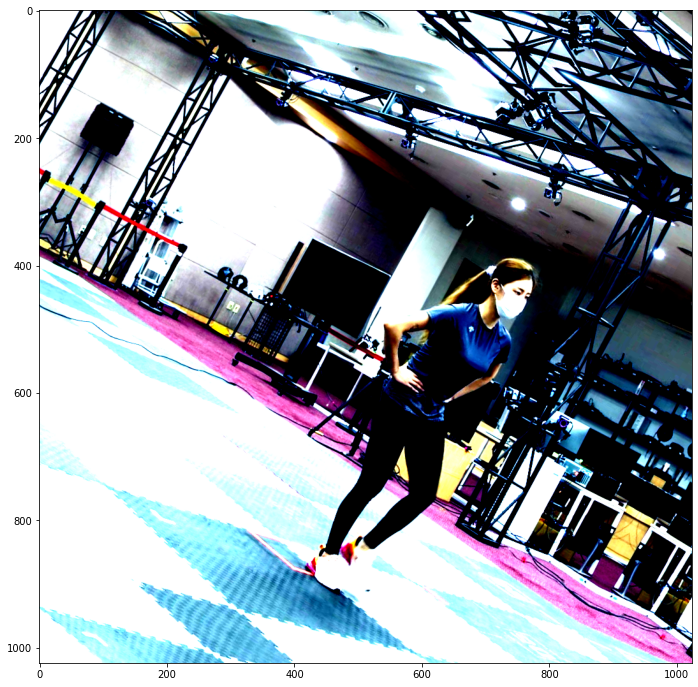

In [96]:
# custom_imshow(sample,keypointss)
custom_imshow(sample)

In [97]:
class HRnetModel(nn.Module):
    def __init__(self, num_classes=48, model_name='hrnet_w48', pretrained=True):
        super(HRnetModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        self.model.classifier = nn.Linear(2048, num_classes)
        
    def forward(self, x):
        x = self.model(x)

        return x

In [98]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HRnetModel().to(device)

# PATH = '/content/gdrive/MyDrive/dacon-motion/checkpoint/model_hrnet_0314_16.pt'
# model = HRnetModel().to(device)

# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict'])


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-hrnet/hrnetv2_w48-abd2e6ab.pth" to /root/.cache/torch/hub/checkpoints/hrnetv2_w48-abd2e6ab.pth


In [99]:
print(summary(model, input_size=(1, 3, 1024, 1024), verbose=0))

Layer (type:depth-idx)                        Output Shape              Param #
├─HighResolutionNet: 1-1                      [1, 48]                   --
|    └─Conv2d: 2-1                            [1, 64, 512, 512]         1,728
|    └─BatchNorm2d: 2-2                       [1, 64, 512, 512]         128
|    └─ReLU: 2-3                              [1, 64, 512, 512]         --
|    └─Conv2d: 2-4                            [1, 64, 256, 256]         36,864
|    └─BatchNorm2d: 2-5                       [1, 64, 256, 256]         128
|    └─ReLU: 2-6                              [1, 64, 256, 256]         --
|    └─Sequential: 2-7                        [1, 256, 256, 256]        --
|    |    └─Bottleneck: 3-1                   [1, 256, 256, 256]        75,008
|    |    └─Bottleneck: 3-2                   [1, 256, 256, 256]        70,400
|    |    └─Bottleneck: 3-3                   [1, 256, 256, 256]        70,400
|    |    └─Bottleneck: 3-4                   [1, 256, 256, 256]        70

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.001)
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
criterion = nn.MSELoss(reduction='sum')
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                  mode='min',
                                                  factor=0.5,
                                                  patience=2,)



for epoch in range(EPOCHS):
    

    for i, (images, targets) in enumerate(train_loader):

        optimizer.zero_grad()

        # images = images.float().to(device)
        images = images.to(device)
        targets = targets.to(device)
        model.train()
        with torch.set_grad_enabled(True):
            outputs = model(images)
            loss = criterion(outputs.float(), targets.float())
            loss.backward()
            optimizer.step()

        if i % 100 == 0:
            outputs = outputs
            
            print(f'{epoch+1}: {loss.item():.5f}')


    with tqdm(val_loader,
            total=val_loader.__len__(),
            unit="batch") as valid_bar:
        for i, (images, targets) in enumerate(valid_bar):
            valid_bar.set_description(f"Valid Epoch {epoch + 1}")
            optimizer.zero_grad()

            images = images.to(device)
            targets = targets.to(device)

            # 모델의 dropoupt, batchnormalization를 eval모드로 설정
            # .forward()에서 중간 노드의 gradient를 계산

            model.eval()

            with torch.no_grad():
                # validation loss만을 계산
                probs  = model(images)
                valid_loss = criterion(probs.float(), targets.float())

            valid_bar.set_postfix(valid_loss = valid_loss.item())

    scheduler.step(valid_loss)


    if (epoch + 1) % 2 == 0:
        torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, f'/content/gdrive/MyDrive/dacon-motion/checkpoint/model_hrnet_0316_{epoch + 1}.pt')
    
    print('------------------')

1: 31.02794
1: 0.87004
1: 1.52864
1: 4.19618
1: 1.20648
1: 2.64463
1: 1.20777
1: 0.81399
1: 0.80739
1: 0.48054
1: 0.34771
1: 1.46800
1: 1.59108
1: 3.28588
1: 3.64035
1: 1.85210
1: 1.55401
1: 2.22385
1: 3.56191
1: 4.08806


Valid Epoch 1: 100%|██████████| 65/65 [00:50<00:00,  1.28batch/s, valid_loss=22.1]


------------------
2: 2.78504
2: 2.88544


In [ ]:
# # 불러와서 예측하기

# PATH = '/content/gdrive/MyDrive/dacon-motion/checkpoint/model_hrnet_0312_20.pt'
# model = HRnetModel().to(device)

# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict'])


In [ ]:
!nvidia-smi

In [ ]:
all_predictions = []
files = []
with torch.no_grad():
    for filenames, inputs in tqdm(test_loader):
        predictions = list(model(inputs.to(device)).cpu().numpy())
        files.extend(filenames)
        for prediction in predictions:
            all_predictions.append(prediction)

In [ ]:
all_predictions[0]

In [ ]:
files[1]

In [ ]:
all_predictions = np.array(all_predictions)
for i in range(all_predictions.shape[0]):
    all_predictions[i, [2*j for j in range(24)]] *= 1024
    all_predictions[i, [2*j + 1 for j in range(24)]] *= 1024

In [ ]:
# submit * 1024 해주어야함.

In [ ]:
submit = pd.read_csv(SUB_DF)
submit.head(2)

In [ ]:
submit = pd.DataFrame(columns=submit.columns)
submit['image'] = files
submit.iloc[:, 1:] = all_predictions
submit.head()

In [ ]:
# inversed = scaler.inverse_transform(submit.iloc[:,1:])
# print(inversed[0])

In [ ]:
# submit.iloc[:,1:] = inversed
# submit.head(2)


In [ ]:
submit[x_coor] = (submit[x_coor] + 426)
submit[y_coor] = (submit[y_coor] + 56)

In [ ]:
submit.head(2)

In [ ]:
submit.to_csv('/content/gdrive/MyDrive/dacon-motion/submit_hr_0316.csv', index=False)

In [ ]:
import glob


In [ ]:
plt.figure(figsize=(40,20))
count=1
test_paths = glob.glob(os.path.join(PATH_TEST_DATASET,'*.jpg'))

for i in np.random.randint(0,len(test_paths),5):
    
    plt.subplot(5,1, count)
    
    img_sample_path = test_paths[i]
    img_name = img_sample_path.split('/')[6]
    img = Image.open(img_sample_path)
    img_np = np.array(img)
    key = submit[submit['image'] == img_name].iloc[0, 1:49]

    keypoint = submit.iloc[:,1:49] #위치키포인트 하나씩 확인

    for j in range(0,len(keypoint.columns),2):
        plt.plot(key[j], key[j+1],'rx')
        plt.imshow(img_np)
    
    count += 1